In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']

data = pd.read_csv("Sales_Analysis.csv",encoding = 'utf8',dtype={'user_id':'int64'}) #integer type is specified for the user id

### Data Cleansing

In [2]:
data.isnull().sum()  #Only the category_code and brand fields have missing values
data['brand'].fillna('no_brand',inplace = True)
data['category_code'].fillna('missing_value',inplace = True)

#Delete the numeric index column of the original data and duplicate data
del data['Unnamed: 0']
data.drop_duplicates(inplace = True)
#there were more than 1,300 pieces of data that generated the error field in 1970,delete it directly
data = data[data['event_time'].str[:4] != '1970']
data['event_time'] = pd.to_datetime(data['event_time'])
data['hour'] = data['event_time'].dt.hour
data['event_time'] = data['event_time'].dt.to_period('D')
data['month'] = data['event_time'].dt.month
#reset index
data = data.set_index('event_time',drop = False)
data.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,hour,month
event_time,,,,,,,,,,,,,
2020-04-24,2020-04-24,2294359932054530000,1515966223509080000,2268105426648170000,electronics.tablet,samsung,162.01,1515915625441990000,24,女,海南,11,4
2020-04-24,2020-04-24,2294444024058080000,2273948319057180000,2268105430162990000,electronics.audio.headphone,huawei,77.52,1515915625447870000,38,女,北京,14,4
2020-04-24,2020-04-24,2294584263154070000,2273948316817420000,2268105471367840000,missing_value,karcher,217.57,1515915625443140000,32,女,广东,19,4
2020-04-26,2020-04-26,2295716521449610000,1515966223509260000,2268105442636850000,furniture.kitchen.table,maestro,39.33,1515915625450380000,20,男,重庆,8,4
2020-04-26,2020-04-26,2295740594749700000,1515966223509100000,2268105428166500000,electronics.smartphone,apple,1387.01,1515915625448760000,21,男,北京,9,4


### Data Analysis

**Preliminary analysis of the order**  
To view the data situation and e-commerce data, according to the time dimension, view the field information such as monthly sales, monthly paying persons, monthly orders, monthly arpu value, etc., to understand the basic situation of store sales;

In [3]:
#According to the time dimension, monthly sales, monthly payers, monthly orders, monthly arpu value, etc.；
df = data.groupby('month').agg({'price':'sum','user_id':'nunique','order_id':'count'})
df.columns = ['revenue','cust_count','order_count']
df['arpu'] = df['revenue'] / df['cust_count']
df['order_per_user'] = df.order_count / df.cust_count
df

,revenue,cust_count,order_count,arpu,order_per_user
month,,,,,
1,1772930.77,1319,14206,1344.147665,10.770281
2,2258926.07,1508,17927,1497.961585,11.887931
3,2888256.58,1597,18629,1808.551396,11.664997
4,1694716.89,1525,11817,1111.289764,7.748852
5,7729865.19,3168,40040,2439.982699,12.638889
6,7661574.13,3966,41148,1931.813951,10.375189
7,16292193.15,5159,75989,3158.013791,14.729405
8,27890706.05,6213,99508,4489.088371,16.016095
9,17098325.54,5497,70156,3110.483089,12.762598


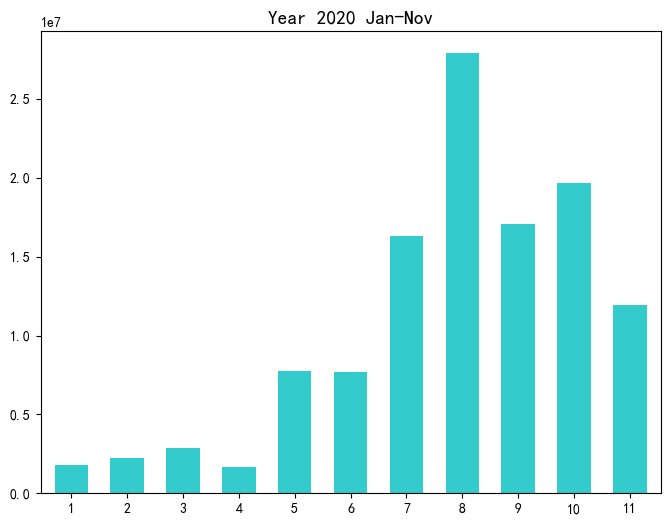

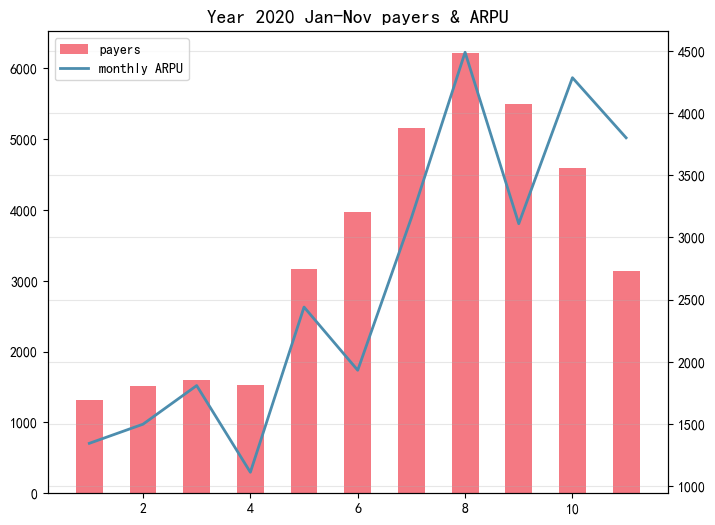

In [4]:
#plot1
df['revenue'].plot(kind = 'bar',
                   color = 'c',
                   alpha = 0.8,
                   width = 0.6,
                   label = 'monthly income',
                   figsize=(8,6))
plt.title('Year 2020 Jan-Nov',fontsize = 14)
plt.xticks(rotation = 0)
plt.xlabel('')
#plot2
fig,ax = plt.subplots(figsize = (8,6))
ax1 = ax.twinx()
ax.bar(df.index,df['cust_count'].values,
       color = '#f47983',
       width = 0.5,
       label = 'payers')
ax1.plot(df.index,df['arpu'].values,
         color = '#4c8dae',
         lw = 2,
         label = 'monthly ARPU')
plt.xlabel('')
lines1, labels1 = ax.get_legend_handles_labels() 
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc=2)
plt.title('Year 2020 Jan-Nov payers & ARPU',fontsize = 14)
plt.grid(axis = 'y',alpha = 0.3)

- Observing the chart, it can be found that revenue has suddenly increased significantly since May, reached its peak in August, and then began to fall;
- The corresponding monthly payment numbers showed the same trend, but the monthly arpu value dropped suddenly in April, and then slowly recovered, all the way up;
- Data showed inflection points in April and September, respectively, and the preliminary speculation is related to the introduction of new payment users (the variables that can be seen here are only new users, you can also check whether there are changes in product structure, pricing, etc., here Limited data, do not do too much analysis);
- Number of orders per month per capita is 7 before and after, and becomes 2 in the middle when a large number of new users are introduced. It is conceivable that the repurchase situation of introduced users is also worth exploring;

### Customer Analysis

In [5]:
#monthly new payer 、first order arpu、monthly repurchase rate、monthly repurchase arpu等；
df_user = pd.pivot_table(data,columns='month',index='user_id',values='price',aggfunc='sum')
user_record = df_user.fillna(0)
user_record = user_record.applymap(lambda x: 1 if x > 0 else 0)
#Build a function to find monthly new users (first-time paying users)
def new(x):
    s = x.idxmax()
    x[s] = 'new'
    return(x)
user_record = user_record.apply(new,axis=1)
new_user_month = user_record.apply(lambda x: pd.value_counts(x)).T
new_user_month = new_user_month.drop([0,1],axis = 1)
new_user_month #Get the monthly number of new consumers per month
# new_user_month.plot(kind='bar')

,new
month,
1,1319.0
2,746.0
3,466.0
4,406.0
5,882.0
6,788.0
7,885.0
8,1170.0
9,104.0


In [6]:
#Continue to calculate the first arpu and monthly repurchase arpu of new users
#First calculate the first order flow, the first order arpu
first_paid = {}
for i in range(1,12):
    order_i = data[data['month'] == i].drop_duplicates(subset='user_id',keep='first') #Get the first order of each user in each month
    user_id_i = user_record[user_record[i] == 'new'].index #Get the monthly user id
    first_paid[i] = order_i[order_i['user_id'].isin(user_id_i)]['price'].sum() #Solve the 1st order of the new user
    
new_user_month['first_paid'] = first_paid.values()
new_user_month['first_paid_arpu'] = new_user_month['first_paid'] / new_user_month['new'] #1st order arpu

In [7]:
#Then calculate the number of repurchases users and the repurchase sales
df_user2 = pd.pivot_table(data,columns='month',index='user_id',values='order_id',aggfunc='count').fillna(0)
new_rep = {} #new repurchasers
re_paid = {} #repurchase sales
for i in range(1,12):
    user_id_i = user_record[user_record[i] == 'new'] #Get new monthly users df
    order_id_i = df_user2[df_user2[i] >= 2].index #Get the user id whose monthly order number is greater than 1
    new_rep[i] = len(user_id_i[user_id_i.index.isin(order_id_i)]) #the number of repurchasers
    re_paid[i] = data[data['user_id'].isin(user_id_i.index)]['price'].sum() #Total monthly turnover of new users

new_user_month['new_rep'] = new_rep.values() #Number of new purchases
new_user_month['re_paid'] = re_paid.values() #New month total sales
new_user_month['re_paid'] = new_user_month['re_paid'] - new_user_month['first_paid'] #Reduced to get the new users and repurchase flow
new_user_month['new_rep_rate'] = new_user_month['new_rep'] / new_user_month['new'] #Monthly repurchase rate
new_user_month['re_paid_arpu'] = new_user_month['re_paid'] / new_user_month['new_rep'] #repurchase arpu
new_user_month['new_no_rep'] = new_user_month['new'] - new_user_month['new_rep'] #New users who have not repurchased
new_user_month

,new,first_paid,first_paid_arpu,new_rep,re_paid,new_rep_rate,re_paid_arpu,new_no_rep
month,,,,,,,,
1,1319.0,162045.51,122.854822,750,26567244.33,0.568613,35422.992440,569.0
2,746.0,100263.39,134.401327,405,12097008.79,0.542895,29869.157506,341.0
3,466.0,81263.85,174.385944,246,10630971.98,0.527897,43215.333252,220.0
4,406.0,70940.60,174.730542,255,9084541.48,0.628079,35625.652863,151.0
5,882.0,193414.70,219.291043,680,13091815.80,0.770975,19252.670294,202.0
6,788.0,169679.47,215.329277,617,7266841.02,0.782995,11777.700194,171.0
7,885.0,212657.28,240.290712,756,11651083.57,0.854237,15411.486204,129.0
8,1170.0,412899.10,352.905214,1051,14472662.43,0.898291,13770.373387,119.0
9,104.0,38260.37,367.888173,82,6364915.28,0.788462,77620.918049,22.0


Text(0.5, 1.0, 'Repurchase amount and arpu of new consumers in each month of 2020')

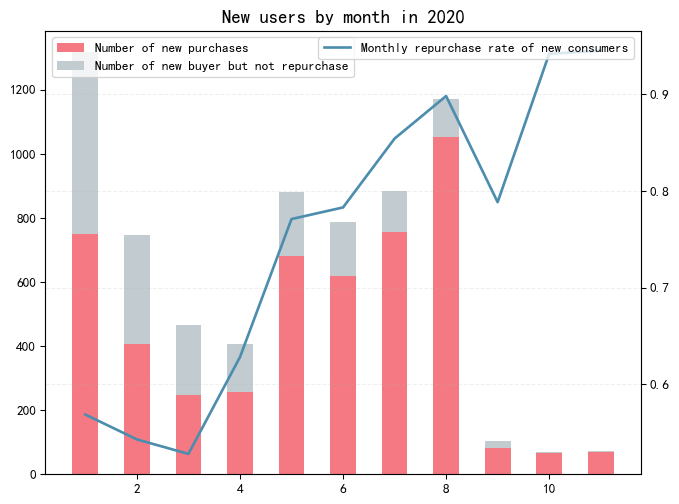

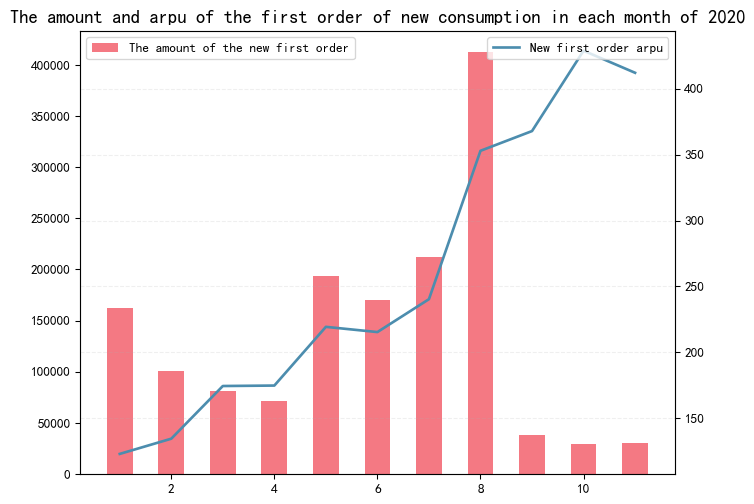

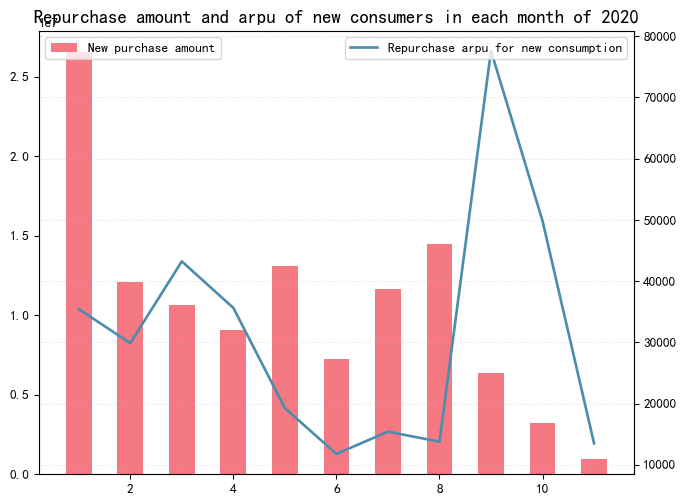

In [8]:
#plot1
fig,ax = plt.subplots(figsize=(8,6),dpi = 96)
ax1 = ax.twinx()
ax.bar(new_user_month.index,new_user_month['new_rep'].values,width=0.5,color ='#f47983',label='Number of new purchases')
ax.bar(new_user_month.index,new_user_month['new_no_rep'].values,bottom=new_user_month['new_rep'].values,width=0.5,color = '#c2ccd0',label='Number of new buyer but not repurchase')
ax1.plot(new_user_month.index,new_user_month['new_rep_rate'].values,color = '#4c8dae',lw = 2,label = 'Monthly repurchase rate of new consumers')
ax.legend(loc = 2)
ax1.legend(loc = 1)
plt.grid(alpha = 0.2,axis = 'y',ls = '--')
plt.title('New users by month in 2020',fontsize = 14)
#plot2
fig,ax = plt.subplots(figsize=(8,6),dpi = 96)
ax1 = ax.twinx()
ax.bar(new_user_month.index,new_user_month['first_paid'].values,width=0.5,color ='#f47983',label='The amount of the new first order')
ax1.plot(new_user_month.index,new_user_month['first_paid_arpu'].values,color = '#4c8dae',lw = 2,label = 'New first order arpu')
ax.legend(loc = 2)
ax1.legend(loc = 1)
plt.grid(alpha = 0.2,axis = 'y',ls = '--')
plt.title('The amount and arpu of the first order of new consumption in each month of 2020',fontsize = 14)
#plot3
fig,ax = plt.subplots(figsize=(8,6),dpi = 96)
ax1 = ax.twinx()
ax.bar(new_user_month.index,new_user_month['re_paid'].values,width=0.5,color ='#f47983',label='New purchase amount')
ax1.plot(new_user_month.index,new_user_month['re_paid_arpu'].values,color = '#4c8dae',lw = 2,label = 'Repurchase arpu for new consumption')
ax.legend(loc = 2)
ax1.legend(loc = 1)
plt.grid(alpha = 0.2,axis = 'y',ls = '--')
plt.title('Repurchase amount and arpu of new consumers in each month of 2020',fontsize = 14)


- The trend of the number of new customers in the month is basically the same as the trend of the total number of payers. There was a relatively large increase between April and August. It is speculated that there should be a large investment in new operations during this period;  
- But the quality of new consumers does not seem to be good. Since April, the repurchase arpu of new consumers has been declining all the way, and has never returned to the arpu data before March; the monthly repurchase rate of new consumers from April to July is lower than the first 3 months,  
- New customer first order arpu has maintained a stable growth trend. It seems that the operation strategy should stimulate the first order consumption of new users better, but unfortunately the repurchase is not good.

In [9]:
# The first picture only reflects the repurchase of the new consumer in the current month, and the operation generally needs to see the continuous repurchase situation in each month;
#Calculate the repurchase rate of each month's new purchases in subsequent months
new_k = {}
for i in range(1,11):
    new_user = []
    df_new = user_record[user_record[i] == 'new']
    new_user.append(len(df_new)) 
    for j in range(i+1,12):
        new_j = df_new[j].sum()
        new_user.append(new_j)
    new_k[i] = new_user
    if i > 1:
        for k in range(i-1):
            new_k[i].insert(0,np.nan)
df_new_rep =  pd.DataFrame(new_k,index = range(1,12))
df_new_rep #columns is each month, index is the repurchase of each month in the following months;

,1,2,3,4,5,6,7,8,9,10
1,1319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,762,746.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,771,360.0,466.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,658,293.0,168.0,406.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1075,557.0,335.0,319.0,882.0,NaN,NaN,NaN,NaN,NaN
6,1203,653.0,386.0,302.0,634.0,788.0,NaN,NaN,NaN,NaN
7,1275,716.0,440.0,372.0,780.0,691.0,885.0,NaN,NaN,NaN
8,1284,732.0,440.0,381.0,799.0,695.0,712.0,1170.0,NaN,NaN
9,1225,671.0,416.0,348.0,704.0,609.0,617.0,803.0,104.0,NaN
10,1071,553.0,358.0,293.0,581.0,481.0,513.0,601.0,77.0,69.0


Text(0.5, 1.0, 'Monthly new user repurchase rate curve')

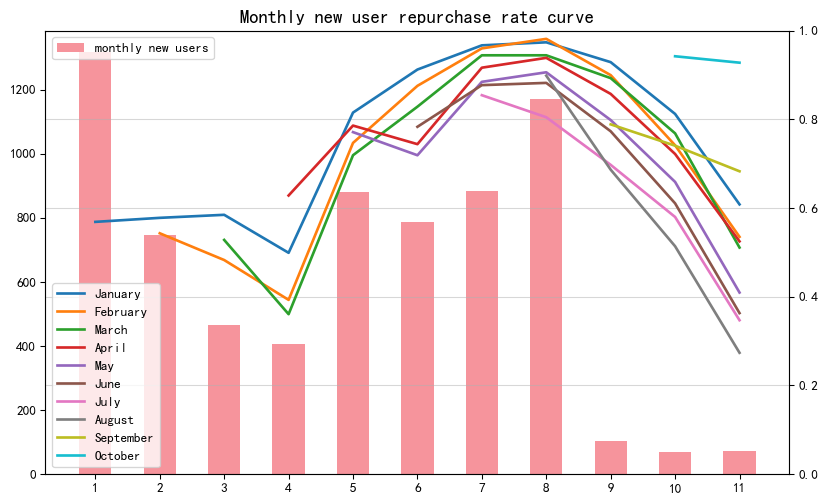

In [10]:
#converted into repurchase rate;
for n in range(1,11):
    df_new_rep[n] = df_new_rep[n] / df_new_rep[n][n]
    df_new_rep[n][n] = new_user_month['new_rep_rate'][n]
df_new_rep.columns = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

#plot4
fig,ax = plt.subplots(figsize = (10,6),dpi=96)
ax2 = ax.twinx()
ax.bar(new_user_month.index,new_user_month['new'].values,color='#f47983',width=0.5,alpha = 0.8,label = 'monthly new users')
df_new_rep.plot(kind = 'line',
                ylim = (0,1),
                lw = 2,
                ax = ax2)
plt.xticks(range(1,12))
ax.legend(loc=2)
plt.grid(alpha = 0.5)
plt.legend()
plt.title('Monthly new user repurchase rate curve',fontsize = 14)

- The follow-up repurchase rate of new purchases from January to March is significantly better than that of new purchases after April, which means that the quality of new purchases starting in April is not very good;
- The operation strategy implemented in May has greatly improved the repurchase rate of new users before, and it is worth promoting;
- The growth of new purchases in July and August was the peak, and the repurchase rate in the following month was only about 20%;

In [11]:
#Operationally, users can be divided into 5 categories according to their status in the previous cycle: new purchases of the current month, new purchases of last month, repurchase this month, old purchases of last month, repurchase this month, payment last month, repurchase this month, Lost in February + repurchase this month;
#Build a function to divide payment user tags;
def customer_label(x):
    label = []
    for i in range(1,12):
        if x[i] == 0:
            label.append('unpaid')
        else:
            if i == 1:
                label.append('new purchase current month')
            elif i == 2:
                label.append('new purchase current month') if label[i-2] == 'unpaid' else label.append('new purchase last month and repurchase this month')
            elif i == 3:
                if label[i-2] == 'unpaid':
                    label.append('monthly new buyer') if label[i-3] == 'unpaid' else label.append('Paid before last month and repurchase this month')
                else:
                    label.append('new purchase last month and repurchase this month') if label[i-3] == 'unpaid' else label.append('last month old customer repurchase this month')
            else:
                if len(set(label)) == 1:  #The previous elements are all unpaid
                    label.append('new purchase current month')
                elif label[i-2] == 'new purchase current month':
                    label.append('new purchase last month and repurchase this month')
                elif (label[i-2] != 'new purchase current month') & (label[i-2] != 'unpaid'):
                    label.append('old purchase last month and repurchase this month')
                elif (label[i-2] == 'unpaid') & (label[i-3] != 'unpaid'):
                    label.append('Paid before last month and repurchase this month')
                elif (label[i-2] == 'unpaid') & (label[i-3] == 'unpaid'):
                    label.append('churned two month and repurchase this month')
                else:
                    label.append('others')
    return(pd.Series(label,index=range(1,12)))

user_info = df_user.fillna(0).applymap(lambda x:1 if x > 0 else 0)
user_info = user_info.apply(customer_label,axis=1)
user_paid_label = user_info.apply(lambda x: pd.value_counts(x)).T.fillna(0) #the components of monthly payer
del user_paid_label['unpaid']
user_paid_label.head()

,Paid before last month and repurchase this month,churned two month and repurchase this month,last month old customer repurchase this month,monthly new buyer,new purchase current month,new purchase last month and repurchase this month,old purchase last month and repurchase this month
1,0.0,0.0,0.0,0.0,1319.0,0.0,0.0
2,0.0,0.0,0.0,0.0,746.0,762.0,0.0
3,253.0,0.0,518.0,466.0,0.0,360.0,0.0
4,196.0,86.0,0.0,0.0,406.0,0.0,837.0
5,534.0,374.0,0.0,0.0,882.0,319.0,1059.0


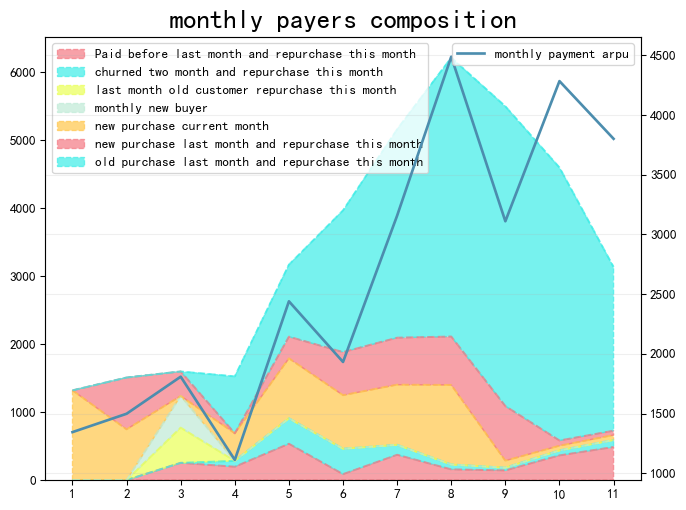

In [12]:
#plot: Stacked Plots
fig,ax = plt.subplots(figsize = (8,6),dpi = 96)
ax1 = ax.twinx()
user_paid_label.plot(kind = 'area',
                     color=['#f47983','#3eede7','#eaff56','#c0ebd7','#ffc64b'],
                     alpha = 0.7,
                     linestyle = '--',
                     ax = ax)
ax1.plot(df.index,df['arpu'].values,
         color = '#4c8dae',
         lw = 2,
         label = 'monthly payment arpu')
plt.title('monthly payers composition',fontsize = 20)
plt.xticks(range(1,12))
ax.legend(loc=2)
ax1.legend(loc = 1)
plt.grid(alpha = 0.2)

- Paying user composition chart, you can understand the composition and quality of the monthly paying population in detail;
- In April, the monthly new consumption increased, but the arpu was the lowest in that month. It can be speculated that the new methods such as price reduction/coupon issuance/discount have been adopted. There are many payers but less actual income;
- Starting in September, the growth of new purchases has decreased, but the arpu value has turned high. It can be seen that the number of repurchasing users in the next few months has accumulated a lot, which is also the reason why the subsequent income can continue to grow;
- July and August did a good job of returning lost users;
- There is no detailed repurchase curve for each group of people. In fact, combined with the analysis of the user life cycle, it can be found that the repurchase of users within 2 months (8 weeks) is very important;

In [13]:
#The above picture shows the composition of monthly payment users, and continues to see the cumulative development of users；
def user_status(x):
    status = []
    for i in range(1,12):
        if x[i] == 0:
            if i == 1:
                status.append('unreg')
            else:
                status.append('unreg') if status[i-2] == 'unreg' else status.append('silent')
        else:
            if i == 1:
                status.append('new')
            else:
                status.append('new') if status[i-2] == 'unreg' else (status.append('return') if status[i-2] == 'silent' else status.append('active') )
    return(pd.Series(status,index = range(1,12)))

user_record = df_user.fillna(0).applymap(lambda x:1 if x > 0 else 0)
user_record = user_record.apply(user_status,axis = 1)
#Count the number of people to 5 kinds of tags
user_type = user_record.apply(lambda x: pd.value_counts(x)).T.fillna(0).drop(columns='unreg')

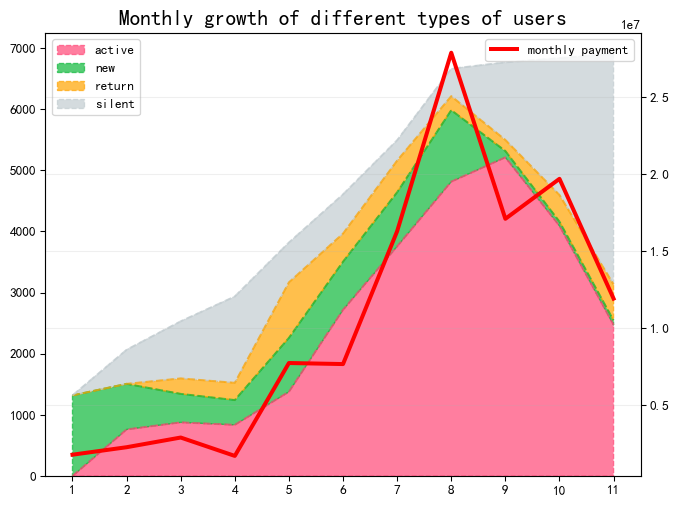

In [14]:
#visualization
fig,ax = plt.subplots(figsize = (8,6),dpi = 96)
ax1 = ax.twinx()
user_type.plot(kind = 'area',
               color=['#ff4777','#0eb83a','#ffa400','#c2ccd0'],
               alpha = 0.7,
               linestyle = '--',
               ax = ax)
df['revenue'].plot(color = 'r',
                   ax =ax1,
                   lw = 3,
                   label = 'monthly payment')
plt.title('Monthly growth of different types of users',fontsize = 16)
plt.legend()
plt.xticks(range(1,12))
plt.grid(alpha = 0.2)

- Actually, the definition of some user behaviors in this picture is not rigorous enough, but this idea is worth learning, and its focus should be on the growth of users;
- It can be found that a large number of users eventually turned into silent users and lost it. To measure this ratio, you can know the advantages and disadvantages of new channels, as well as information such as cost and efficiency;

### User Lifecycle Analysis
- The composition of users has been analyzed above, and information such as their behavior and payment ability has been understood. Next, it is necessary to continue to analyze the attributes of users to further understand their life cycle, growth system, etc.;
- Users can be divided into horizontal and vertical dimensions in terms of user operations;
- horizontally, according to the number of user payments, the more the number of payments, the more stable the user is, and it is divided into: primary users, growing users, and mature users;
- Vertical, according to the number of days between payments, most of the payments occur within a certain length of time, and they are divided into: active users, early warning users, silent users, and lost users;

In [15]:
#First, define the user's active, declining and other nodes;
#Find the distribution of the last two payment intervals of the user
df_paytimes = data.groupby('user_id').order_id.count().reset_index(drop = False)
data_1 = data[data['user_id'].isin(df_paytimes[df_paytimes['order_id'] >= 2].user_id)].reset_index(drop=True) #Filter out users with less than 2 orders
user_paytimes = data_1.pivot_table(index='user_id',columns='event_time',values='order_id',aggfunc='count').fillna(0)
#Build a function to get the number of days between the last 2 purchases of each user;
def user_interval(x):
    mark = 0
    for i in range(1,len(x)+1):
        if x.iloc[-i] != 0:
            if mark == 0:
                a = i
                mark += 1
            else:
                a = i - a
                return(a)
interval_count = user_paytimes.apply(user_interval,axis = 1).dropna()
interval_count = pd.DataFrame(interval_count,columns=['interval_days'])
interval_counts = pd.DataFrame(interval_count['interval_days'].value_counts().sort_index())
interval_counts['rate_sum'] = interval_counts['interval_days'].cumsum()/interval_counts['interval_days'].sum()

Text(0.5, 1.0, 'Distribution of the last two payment intervals by users (days)')

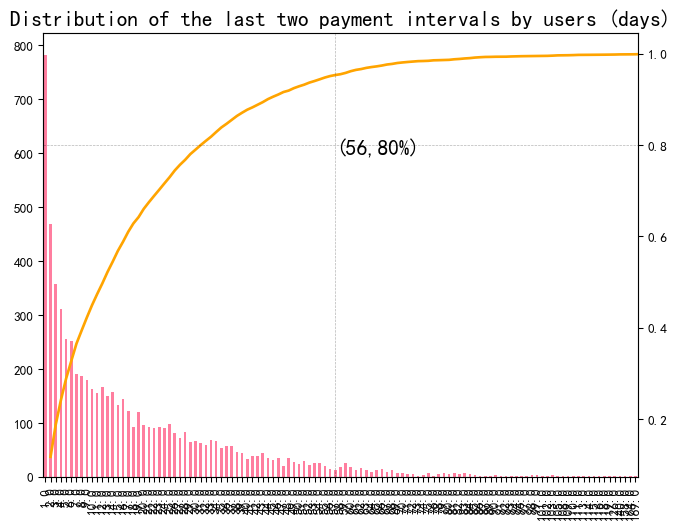

In [16]:
#Drawing: Histogram + Pareto Chart
fig,ax = plt.subplots(figsize = (8,6),dpi = 96)
ax1 =ax.twinx()
interval_counts['interval_days'].plot(kind = 'bar',
                                      color = '#ff4777',
                                      ax = ax,
                                      alpha = 0.7)
interval_counts['rate_sum'].plot(kind = 'line',
                                 color = '#ffa400',
                                 lw = 2)
plt.axhline(y = 0.8,c='black',ls = '--',lw = 0.5,alpha = 0.3)
plt.axvline(x = 56,c='black',ls = '--',lw = 0.5,alpha = 0.3)
plt.text(56,0.78,'(56,80%)',fontsize=16)
plt.title('Distribution of the last two payment intervals by users (days)',fontsize = 16)

In [17]:
#Find the user's maximum payment interval between two consecutive times;
#build function
def max_interval(x):
    a = []
    b = []
    for k in range(len(x)):
        if x.iloc[k] != 0:
            a.append(k)
    if len(a) >1:
        for n in range(len(a)-1):
            d = a[n+1] - a[n]
            b.append(d)
        return(max(b))
    else:
        return(np.nan)
max_interval_count = user_paytimes.apply(max_interval,axis = 1).dropna()
max_interval_count = pd.DataFrame(max_interval_count,columns=['max_interval'])
max_interval_counts = pd.DataFrame(max_interval_count['max_interval'].value_counts().sort_index())
max_interval_counts['rate_sum'] = max_interval_counts['max_interval'].cumsum()/max_interval_counts['max_interval'].sum()

Text(0.5, 1.0, 'Distribution of the maximum payment interval between two consecutive users (days)')

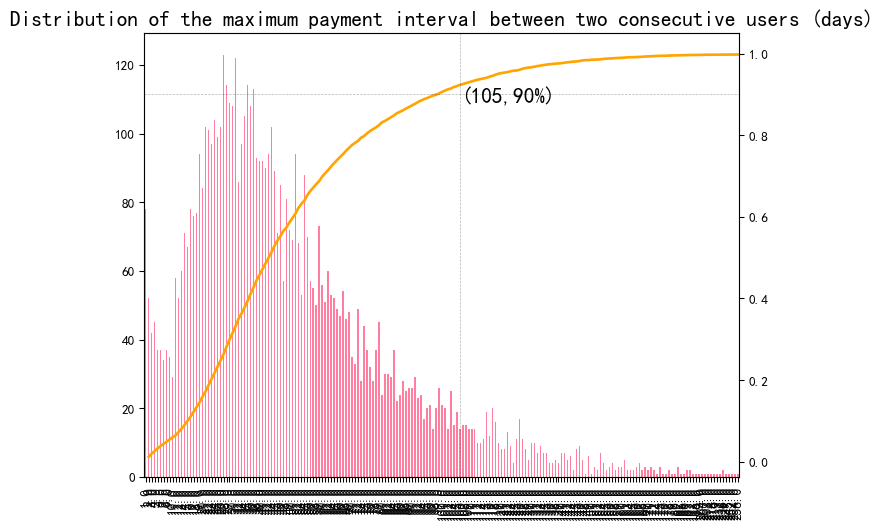

In [18]:
#Drawing: Histogram + Pareto Chart
fig,ax = plt.subplots(figsize = (8,6),dpi = 96)
ax1 =ax.twinx()
max_interval_counts['max_interval'].plot(kind = 'bar',
                                          color = '#ff4777',
                                          ax = ax,
                                          alpha = 0.7)
max_interval_counts['rate_sum'].plot(kind = 'line',
                                     color = '#ffa400',
                                     lw = 2)
plt.axhline(y = 0.9,c='black',ls = '--',lw = 0.5,alpha = 0.3)
plt.axvline(x = 105,c='black',ls = '--',lw = 0.5,alpha = 0.3)
plt.text(105,0.88,'(105,90%)',fontsize=16)
plt.title('Distribution of the maximum payment interval between two consecutive users (days)',fontsize = 16)

- From the distribution of the last two payment intervals, it can be found that 70% of the users have the last two payment intervals of 37 days, 80% of the users have two payment intervals of 56 days, and 90% of the users have two payment intervals of 85 days;
- Operationally, 56 days can be defined as the node of the recession period. If the user does not make payment within 56 days (8 weeks) after the first order is placed, it can be recalled by sending push, coupon, etc.;
- Correspondingly, the key operation period for new paying users should be within 56 days (8 weeks);
- It can be seen from the distribution of the maximum payment interval between two consecutive times that 90% of users have two consecutive maximum payment times less than 105 days. It can be considered that if a user does not pay for more than 105 days (15 weeks), the user has been lost;
-  Therefore, the cycle of user decline and loss is defined as: 0-5 weeks from the last payment is active, 5-8 weeks is recession, 8-12 weeks is early warning, 12-15 weeks is silent, more than 15 weeks for loss;

In [19]:
# Next, define the user's growth system horizontally
#Explore the relationship between the number of user payments and the repurchase rate (retention)
#First look at the distribution of user orders from January to March
orders_1_3 = data[data['month'] <= 3].groupby('user_id')[['order_id']].count()
#temp = data[data.user_id.isin(orders_1_3.sort_values().iloc[-2:-1].index)] 
#When checking the id with the highest order volume, it is found that there may be problems with the data. 
#The same id corresponds to multiple user information, and the highest ids have three-month orders as high as four or five hundred orders. Obviously, there is a problem. We can only continue to analyze here.

#order_1_3.describe()Check, the maximum number of orders reaches 540, and the binning will be carried out
order_bins = [0,2,4,6,8,10,12,15,20,30,540]
orders_1_3['order_group'] = pd.cut(orders_1_3['order_id'],bins = order_bins,right = True)
orders_1_3['order_group'].value_counts(normalize = True).sort_index().cumsum()

(0, 2]       0.398097
(2, 4]       0.620936
(4, 6]       0.736717
(6, 8]       0.827121
(8, 10]      0.879064
(10, 12]     0.917922
(12, 15]     0.948454
(15, 20]     0.969865
(20, 30]     0.990880
(30, 540]    1.000000
Name: order_group, dtype: float64

In [20]:
#According to the active, early warning and churn time of the paying user, examine the repurchase rate of users who pay 1-15 times per month and in the next month；
pay_times = pd.DataFrame(np.ones((15,10),dtype=np.int),
                         columns=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October'],
                         index=range(1,16))
for i in range(1,11):
    orders_samp = data[data['month'].isin([i])].groupby('user_id')[['order_id']].count() #sample
    orders_rep = data[data['month'].isin([i+1])].groupby('user_id')[['order_id']].count() #test
    for k in range(1,16):
        user_k = len(orders_samp[orders_samp['order_id'] == k]) #Sample number of orders k
        user_rep_k = len(orders_rep[orders_rep.index.isin(orders_samp[orders_samp['order_id'] == k].index)])
        pay_times.iloc[k-1,i-1] = user_rep_k / (100000 if user_k == 0 else user_k) #avoid denominator of zero

pay_times #index is the number of payments

,January,February,March,April,May,June,July,August,September,October
1,0.481547,0.487762,0.392857,0.745152,0.664198,0.858995,0.738562,0.558081,0.597484,0.377982
2,0.560440,0.552980,0.479651,0.854167,0.740351,0.926136,0.776000,0.640909,0.617647,0.456731
3,0.598837,0.635071,0.552995,0.928571,0.810256,0.942263,0.897959,0.762136,0.673235,0.487223
4,0.659794,0.594406,0.531532,0.947368,0.785311,0.955307,0.914773,0.749367,0.726937,0.520581
5,0.757143,0.627907,0.633333,0.989583,0.852273,0.959459,0.939891,0.775000,0.764706,0.547368
6,0.836735,0.745098,0.666667,0.966292,0.890323,0.967638,0.976589,0.839542,0.789189,0.625000
7,0.652174,0.882353,0.788462,1.000000,0.901316,0.976190,0.965251,0.834395,0.798013,0.618421
8,0.750000,0.724138,0.815789,0.967742,0.909091,0.973118,0.956204,0.869159,0.800000,0.610687
9,1.000000,0.666667,0.869565,0.963636,0.905109,0.985915,0.986957,0.865052,0.846847,0.669643
10,0.875000,0.818182,0.826087,1.000000,0.884058,0.991870,0.990050,0.889764,0.772727,0.650000


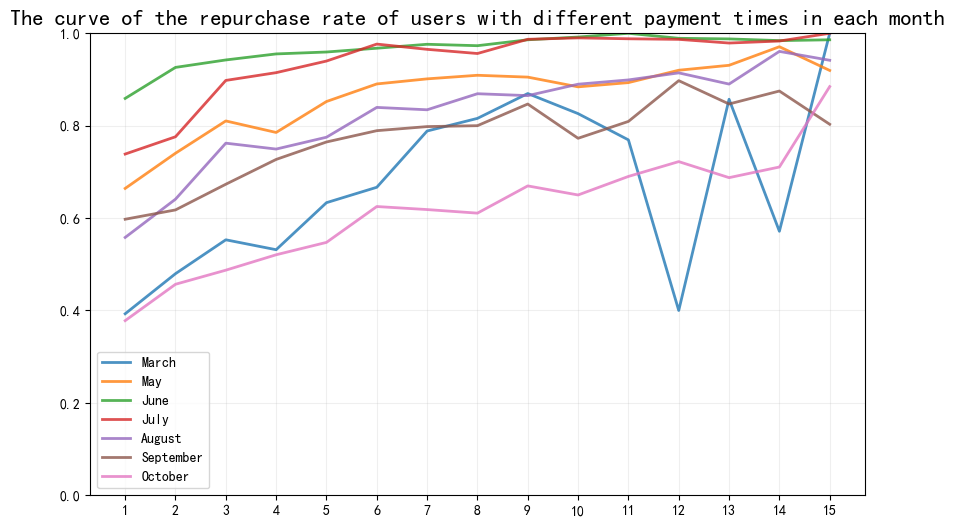

In [21]:
#plot
pay_times[['March', 'May', 'June', 'July', 'August', 'September', 'October']].plot(kind='line',lw=2,alpha=0.8,label='Second month repurchase rate',
                                                             figsize=(10,6)) #Remove the data of January, February and April;
plt.title('The curve of the repurchase rate of users with different payment times in each month',fontsize = 16)
plt.legend(loc = 0)
plt.xticks(range(1,16))
plt.ylim(0,1)
plt.grid(alpha = 0.2)

- Repurchase rate (retention) is positively correlated with the number of payments;
- The number of payments is between 3-6 times, and the repurchase rate has increased significantly;
- After the number of payments reaches 8-10, the repurchase rate (retention) tends to be stable;
- Therefore, users who have paid 1-3 times can be defined as primary users, users who have paid 4-8 times can be defined as growing users, and users who have paid more than 9 times can be defined as mature users;

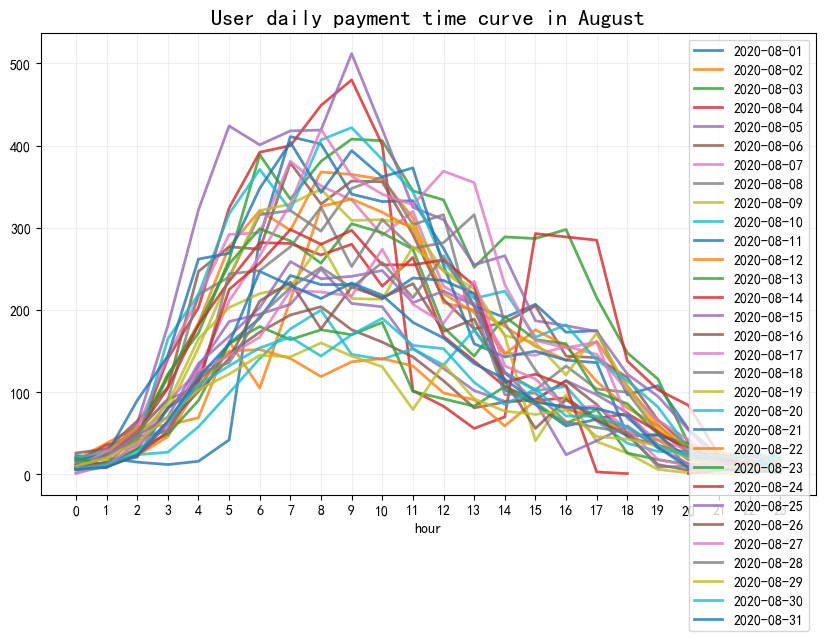

In [22]:
#Daily payment time distribution
pay_days = data[data['month']==8].reset_index(drop=True).pivot_table(index='hour',columns='event_time',values='user_id',aggfunc='count')
#plot
pay_days.plot(kind='line',lw=2,alpha=0.8,figsize=(10,6))
plt.title('User daily payment time curve in August',fontsize = 16)
plt.legend(loc = 0)
plt.xticks(range(0,24))
plt.grid(alpha = 0.2)